#### Import Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

#### Load Dataset and merge them

In [52]:
features = pd.read_csv(r"Data\features.csv")
stores = pd.read_csv(r"Data\stores.csv")
train = pd.read_csv(r"Data\train.csv")
test = pd.read_csv(r"Data\test.csv")
print("features shape :", features.shape)
print("stores shape :", stores.shape)
print("train shape :", train.shape)
print("test shape :", test.shape, "\n")

merged_data = train.merge(features, how="left", on=["Store", "Date", "IsHoliday"])
merged_data = merged_data.merge(stores, how="left", on=["Store"])

merged_data.drop(columns=["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"], inplace=True)
print(merged_data.info())

print("\nData shape: ", merged_data.shape)

features shape : (8190, 12)
stores shape : (45, 3)
train shape : (421570, 5)
test shape : (115064, 4) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  object 
 10  Size          421570 non-null  int64  
dtypes: bool(1), float64(5), int64(3), object(2)
memory usage: 32.6+ MB
None

Data shape:  (421570, 11)


In [53]:
merged_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


#### Data Preprocessing

##### Feature Encoding

In [54]:
data = merged_data[merged_data["Weekly_Sales"]>0].copy()

onehotencoder = OneHotEncoder(sparse_output=False)
encoded_type = onehotencoder.fit_transform(data[["Type"]])
encoded_df = pd.DataFrame(encoded_type, columns=onehotencoder.get_feature_names_out(["Type"]))

data = data.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
data = pd.concat([data, encoded_df], axis=1)
data.drop(columns=["Type"], inplace=True)

data["IsHoliday"] = data["IsHoliday"].map({False: 0, True: 1})

data["Date"] = pd.to_datetime(data["Date"])
data["Year"] = data["Date"].dt.year
data["Week"] = data["Date"].dt.isocalendar().week
# data.drop(columns=["Date"], inplace=True)

print("Data Shape: ", data.shape)

data.head()

Data Shape:  (420212, 15)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_B,Type_C,Year,Week
0,1,1,2010-02-05,24924.50,0,42.31,2.572,211.096358,8.106,151315,1.0,0.0,0.0,2010,5
1,1,1,2010-02-12,46039.49,1,38.51,2.548,211.242170,8.106,151315,1.0,0.0,0.0,2010,6
2,1,1,2010-02-19,41595.55,0,39.93,2.514,211.289143,8.106,151315,1.0,0.0,0.0,2010,7
3,1,1,2010-02-26,19403.54,0,46.63,2.561,211.319643,8.106,151315,1.0,0.0,0.0,2010,8
4,1,1,2010-03-05,21827.90,0,46.50,2.625,211.350143,8.106,151315,1.0,0.0,0.0,2010,9


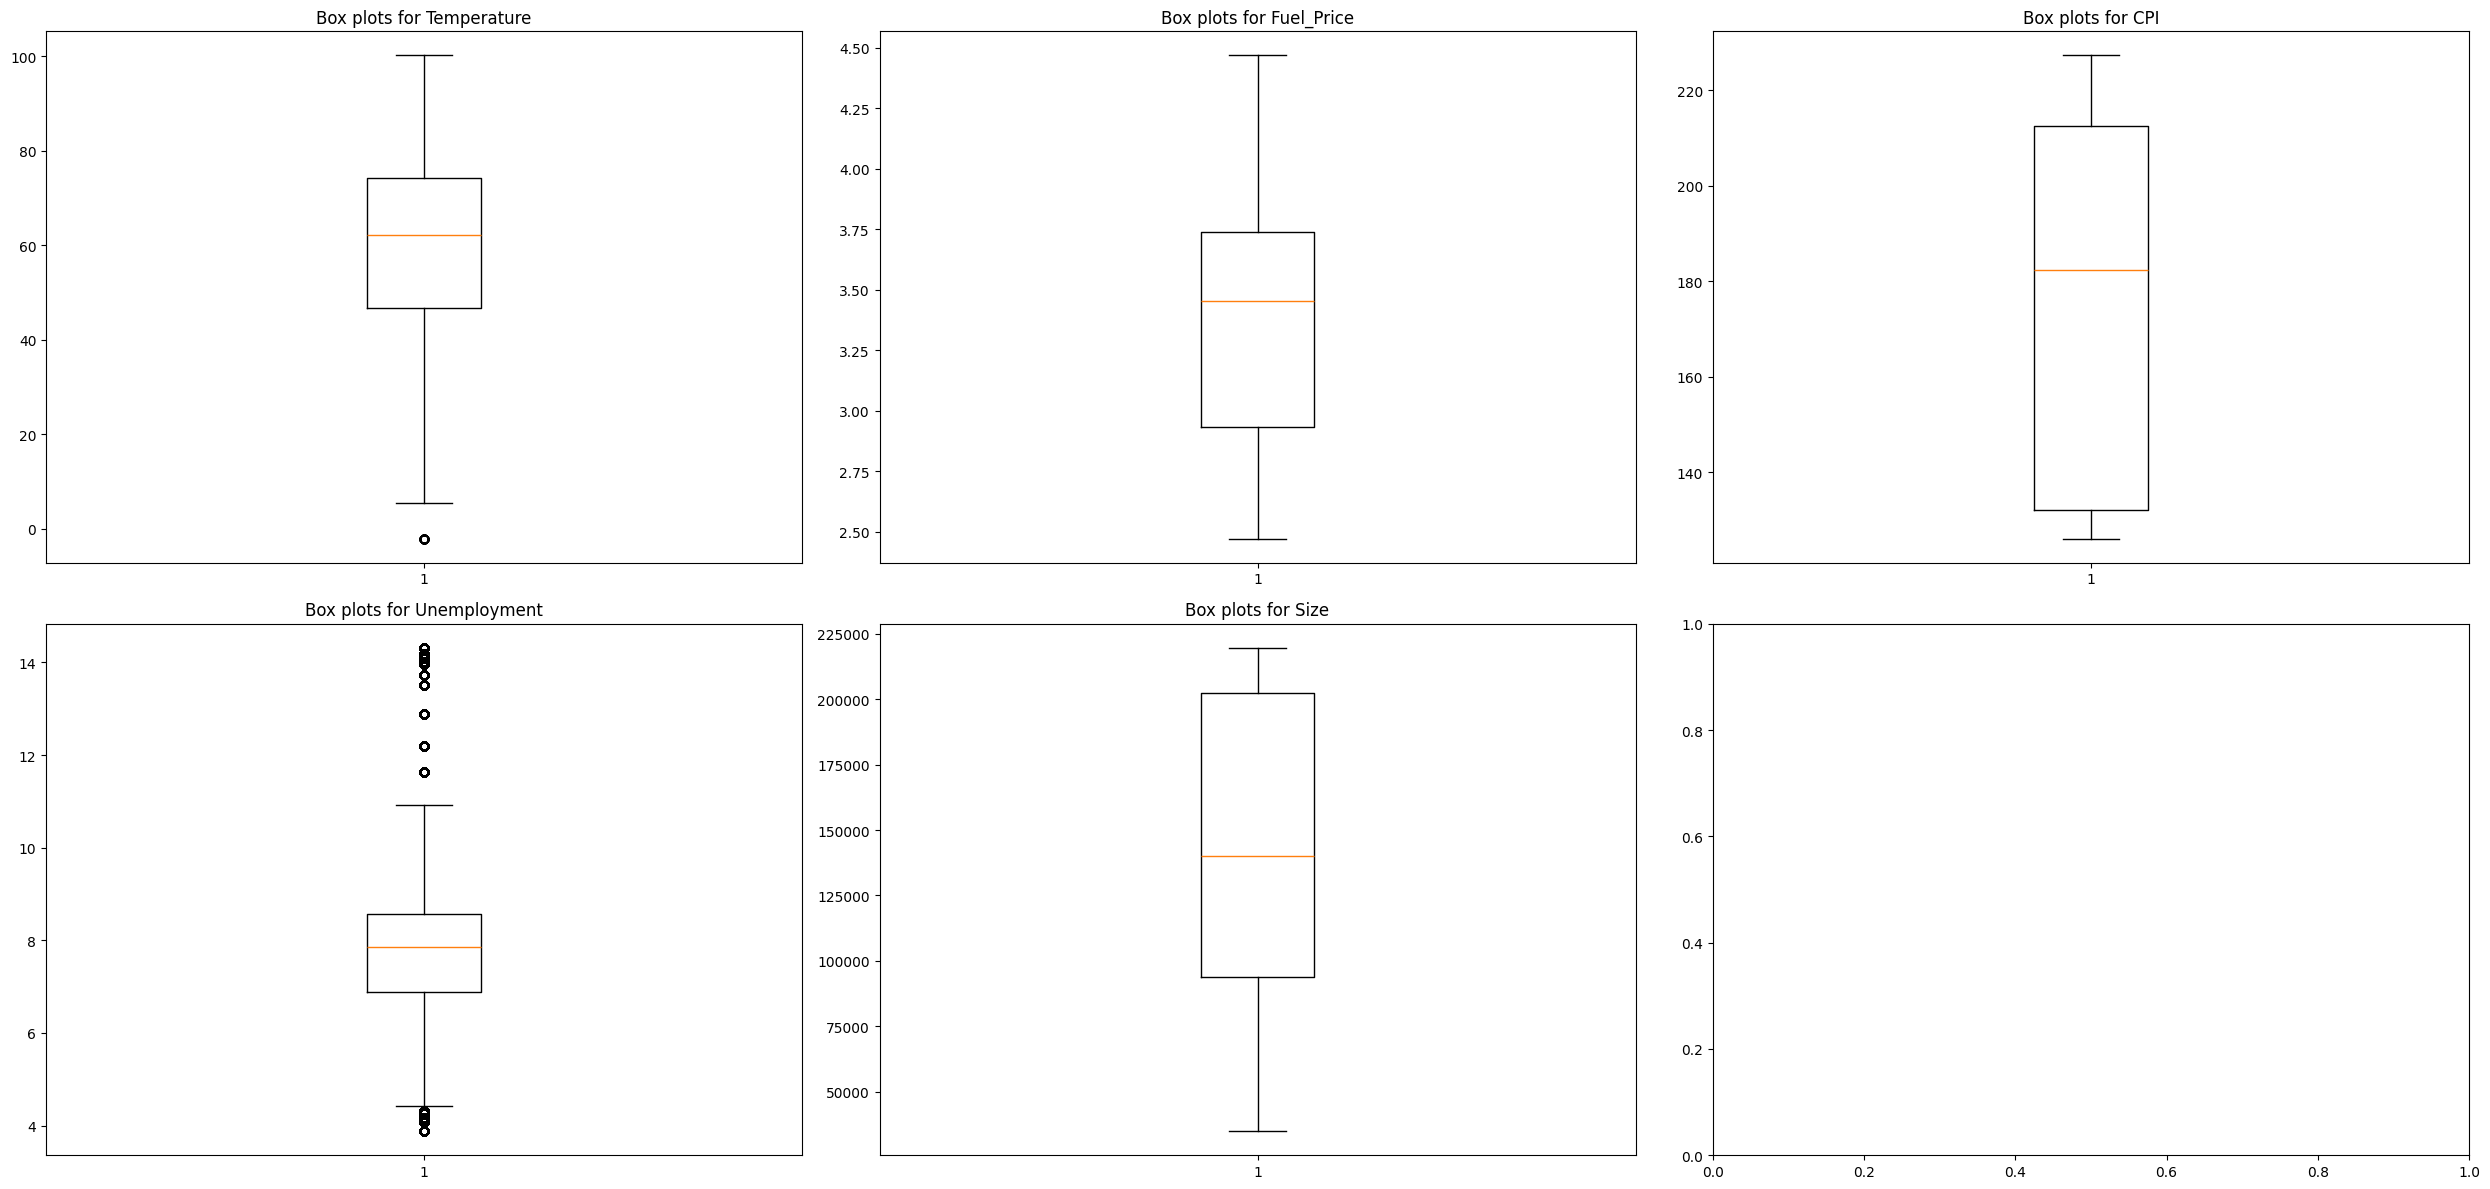

In [55]:
columns_boxplots = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"]
fig, axes= plt.subplots(int(np.ceil(len(columns_boxplots)/3)), 3, figsize=(25,12))
axes = axes.flatten()
for i, column_boxplot in enumerate(columns_boxplots):
    axes[i].boxplot(data[column_boxplot])
    axes[i].set_title(f"Box plots for {column_boxplot}")
plt.tight_layout()
plt.show()

##### Check wether Seasonality and Stationarity are there in this data

In [56]:
sales_avg_by_date = data.groupby("Date")["Weekly_Sales"].mean().reset_index()
sales_avg_by_date

,Date,Weekly_Sales
0,2010-02-05,16887.602166
1,2010-02-12,16390.912208
2,2010-02-19,16255.185970
3,2010-02-26,14955.932194
4,2010-03-05,15964.821240
...,...,...
138,2012-09-28,14815.621125
139,2012-10-05,16037.442175
140,2012-10-12,15484.696200
141,2012-10-19,15311.314544


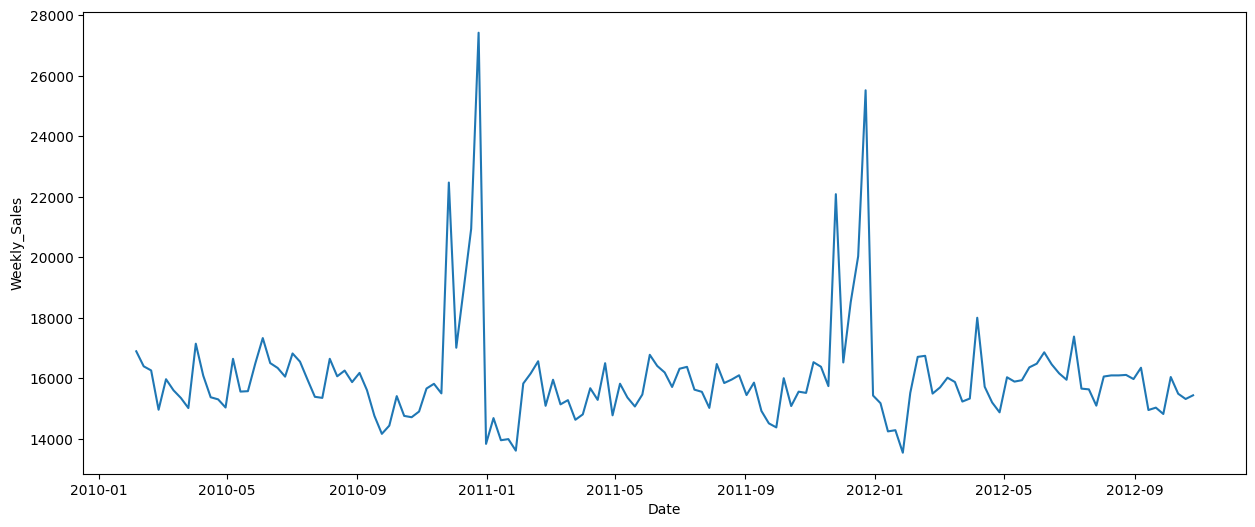

In [57]:
plt.figure(figsize=(15,6))
sns.lineplot(data=sales_avg_by_date, x="Date", y="Weekly_Sales")
plt.show()

- Seasonal patterns in sales just before the year end because of thanksgiving day and christmas day holidays

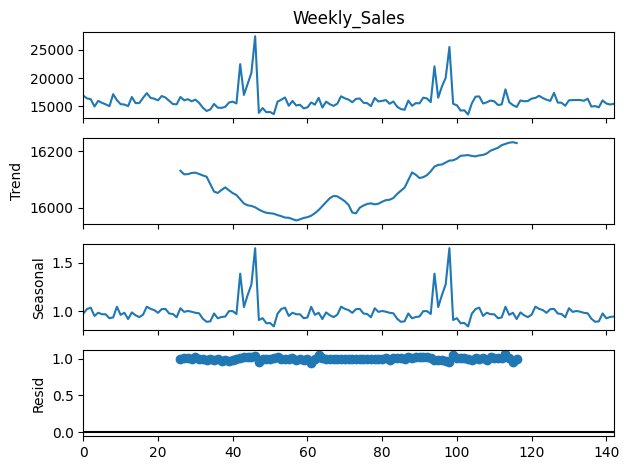

In [58]:
'''Multiplicative Decomposition'''
decomposition_mul_results = seasonal_decompose(sales_avg_by_date["Weekly_Sales"], model='multiplicative', period=52)
decomposition_mul_results.plot()
plt.show()

- There is seasonality in this data

In [59]:
'''Test for Stationarity : Augmented Dickey-Fuller (ADF) Test'''
'''We want to forecast sales for each store and dept, therefore ADF-test needs to be applied on every available pair of store and dept.'''
true_count = 0
false_count = 0
for store in data["Store"].unique():
    for dept in data[data["Store"]==store]["Dept"].unique():
        try:
            temp = data[(data["Store"]==store) & (data["Dept"]==dept)]
            adf_result = adfuller(temp["Weekly_Sales"], autolag='AIC')
            # print("------------------------------------------------------------------------------------------------------------------------")
            if (adf_result[0] < list(adf_result[4].values())[1]) & (adf_result[1] < 0.05):
                # print(f"For Store {store} and Dept {dept} : ")
                # print(f"ADF Statistic: {adf_result[0]}")
                # print(f"p-value: {adf_result[1]}")
                true_count+=1
                # for key, value in adf_result[4].items():
                #     print(f'Critial Values ({key}) :', value)
            else:
                # print(f"Failed for Store {store} and Dept {dept}")  
                false_count+=1          
        except Exception as e:
            # print(f"Data NOT available for store {store} and dept {dept}")
            pass
    # print(f"~~~~~~~~~~~~~~~~~~~\t Store {store} is Done! \t~~~~~~~~~~~~~~~~~~~\n")
    

In [60]:
print(f"Number of Store and Dept pairs that satisfy Stationary condition : {true_count}")
print(f"Number of Store and Dept pairs that do NOT satisfy Stationary condition : {false_count}")

Number of Store and Dept pairs that satisfy Stationary condition : 2257
Number of Store and Dept pairs that do NOT satisfy Stationary condition : 979


- Condition : "P-value < 0.05 & Test Statistics < Critical Value" is satisfied for any Store and Dept, hence we can reject the NULL hypothesis and our data is Stationary.

#### Forecasting

##### SARIMA

In [61]:
data.drop(columns=["Date"], inplace=True)

In [62]:
scaler = MinMaxScaler()

In [63]:
store_dept_data = data[(data["Store"]==1) & (data["Dept"]==1)]
store_dept_data_features = pd.DataFrame(store_dept_data.drop(columns=["Weekly_Sales"], inplace=False))
store_dept_data_target = store_dept_data[["Weekly_Sales"]]

In [64]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

auto_model = auto_arima(store_dept_data_target, seasonal=True, m=52, trace=False, stepwise=True, max_p=3, max_q=3, max_P=2, max_Q=2, suppress_warnings=True)

In [65]:
best_p, best_d, best_q = auto_model.order
best_P, best_D, best_Q, best_s = auto_model.seasonal_order

In [66]:
print(f"Best p : {best_p}\nBest d : {best_d}\nBest q : {best_q}\n")
print(f"Best P : {best_P}\nBest D : {best_D}\nBest Q : {best_Q}")

Best p : 3
Best d : 0
Best q : 1

Best P : 1
Best D : 0
Best Q : 0


In [67]:
# Fit SARIMA model (Example: auto_arima suggested SARIMA(1,1,1)(1,1,1,52))
sarima_model = SARIMAX(store_dept_data_target[:-12], 
                       order=(best_p, best_d, best_q), 
                       seasonal_order=(best_P, best_D, best_Q, best_s), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()
print(sarima_result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  131
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood                -784.568
Date:                             Sat, 22 Mar 2025   AIC                           1581.137
Time:                                     21:37:43   BIC                           1595.121
Sample:                                          0   HQIC                          1586.725
                                             - 131                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0670      1.471     -0.046      0.964      -2.950       2.816
ar.L2          0.0162      

- Seasonal AutoRegressive (52-week lag) is highly significant, confirming strong yearly seasonality.

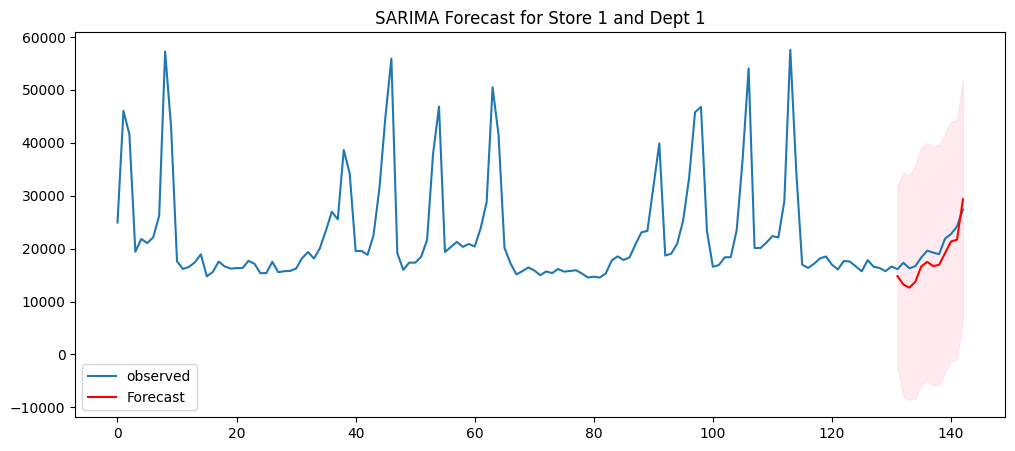

In [68]:
forecast_steps = 12
forecast = sarima_result.get_forecast(steps=forecast_steps)
pred_conf = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(store_dept_data_target, label="observed")
plt.plot(forecast.predicted_mean, label="Forecast", color="red")
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color="pink", alpha=0.3)
plt.title("SARIMA Forecast for Store 1 and Dept 1")
plt.legend()
plt.show()

##### SARIMAX

In [69]:

features = data.drop(columns=["Weekly_Sales"], inplace=False)
target = data[["Weekly_Sales"]]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (294148, 13)
X_test shape:  (126064, 13)
y_train shape:  (294148,)
y_test shape:  (126064,)


In [70]:
X_train.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_B,Type_C,Year,Week
161669,17,34,0,46.94,3.833,131.108000,6.235,93188,0.0,1.0,0.0,2012,15
333742,35,30,0,78.64,3.567,142.233757,8.839,103681,0.0,1.0,0.0,2012,29
185963,19,93,1,31.65,3.566,136.643258,7.866,203819,1.0,0.0,0.0,2011,52
272121,28,46,0,68.27,4.151,128.999867,13.736,206302,1.0,0.0,0.0,2011,17
182623,19,49,0,53.10,3.775,136.472000,7.866,203819,1.0,0.0,0.0,2011,40


In [71]:
sarimax_model = SARIMAX(store_dept_data_target[:-12], 
                        exog=np.asarray(store_dept_data_features, dtype=np.float64)[:-12],  # Exogenous variables
                        order=(best_p, best_d, best_q), 
                        seasonal_order=(best_P, best_D, best_Q, best_s), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_result = sarimax_model.fit()
print(sarimax_result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                        Weekly_Sales   No. Observations:                  131
Model:             SARIMAX(3, 0, 1)x(1, 0, [], 52)   Log Likelihood                -769.210
Date:                             Sat, 22 Mar 2025   AIC                           1576.420
Time:                                     21:37:48   BIC                           1620.704
Sample:                                          0   HQIC                          1594.118
                                             - 131                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015        nan        nan        nan         nan         nan
x1             0.0015      

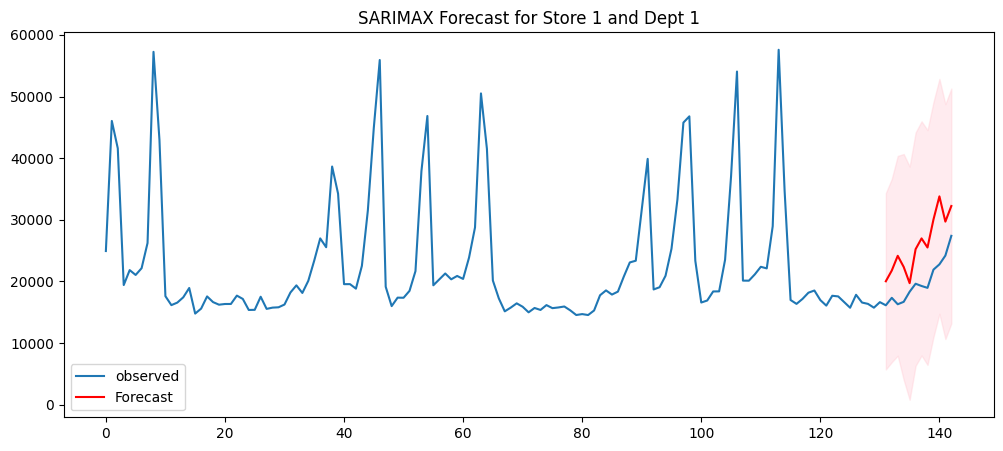

In [72]:
forecast_steps = 12
forecast = sarimax_result.get_forecast(steps=forecast_steps, exog=np.asarray(store_dept_data_features, dtype=np.float64)[-forecast_steps:])
pred_conf = forecast.conf_int()

plt.figure(figsize=(12,5))
plt.plot(store_dept_data_target, label="observed")
plt.plot(forecast.predicted_mean, label="Forecast", color="red")
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color="pink", alpha=0.3)
plt.title("SARIMAX Forecast for Store 1 and Dept 1")
plt.legend()
plt.show()

##### Random Forest

In [73]:
X_train.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Type_A,Type_B,Type_C,Year,Week
161669,17,34,0,46.94,3.833,131.108000,6.235,93188,0.0,1.0,0.0,2012,15
333742,35,30,0,78.64,3.567,142.233757,8.839,103681,0.0,1.0,0.0,2012,29
185963,19,93,1,31.65,3.566,136.643258,7.866,203819,1.0,0.0,0.0,2011,52
272121,28,46,0,68.27,4.151,128.999867,13.736,206302,1.0,0.0,0.0,2011,17
182623,19,49,0,53.10,3.775,136.472000,7.866,203819,1.0,0.0,0.0,2011,40


In [74]:
n_estimators = [100, 250, 500]
for n_estimators_ in n_estimators:
    rf_model = RandomForestRegressor(n_estimators=n_estimators_, max_depth=15)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RF MSE with {n_estimators_} estimators :", mse)

RF MSE with 100 estimators : 4215.562367983582
RF MSE with 250 estimators : 4218.830330056652
RF MSE with 500 estimators : 4216.899914663984


##### XGBoost

In [75]:
n_estimators = [100, 250, 500]
for n_estimators_ in n_estimators:
    xgboost_model = XGBRegressor(n_estimators=n_estimators_, learning_rate=0.1, max_depth=15)
    xgboost_model.fit(X_train, y_train)
    y_pred = xgboost_model.predict(X_test)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"XGBoost MSE with {n_estimators_} estimators :", mse)

XGBoost MSE with 100 estimators : 3036.5389446366235
XGBoost MSE with 250 estimators : 2959.845818350011
XGBoost MSE with 500 estimators : 2940.0529730279713


##### Linear Regression

In [76]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [77]:
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.363636,0.336735,0.0,0.479452,0.681864,0.049857,0.225800,0.315637,0.0,1.0,0.0,1.0,0.274510
1,0.772727,0.295918,0.0,0.789628,0.548597,0.159829,0.475369,0.372434,0.0,1.0,0.0,1.0,0.549020
2,0.409091,0.938776,1.0,0.329843,0.548096,0.104570,0.382116,0.914461,1.0,0.0,0.0,0.5,1.000000
3,0.613636,0.459184,0.0,0.688160,0.841182,0.029019,0.944700,0.927901,1.0,0.0,0.0,0.5,0.313725
4,0.409091,0.489796,0.0,0.539726,0.652806,0.102878,0.382116,0.914461,1.0,0.0,0.0,0.5,0.764706


In [78]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)
mse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression MSE with {n_estimators_} estimators :", mse)

Linear Regression MSE with 500 estimators : 21464.888464263364
